In [11]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [13]:
!nvidia-smi

Fri Jun  3 11:47:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 7.5 MB/s 
     |████████████████████████████████| 3.5 MB 8.4 MB/s 
     |████████████████████████████████| 407 kB 9.9 MB/s 


In [15]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

import torch.nn.functional as F

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [16]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [17]:
fix_random(42)

# Loading the Dataset

In [18]:
base_url = 'https://files.grouplens.org/datasets/movielens/'

##Dataset ml-latest-small

The dataset `ml-latest-small` describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains `100836` ratings and `3683` tag applications across `9742` movies. These data were created by `610` users.

In [ ]:
url = base_url + 'ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

Extracting ./ml-latest-small.zip


In [ ]:
# load user and movie nodes
def load_node_csv(path, index_col):
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

user_mapping = load_node_csv(rating_path, index_col='userId')
movie_mapping = load_node_csv(movie_path, index_col='movieId')

In [ ]:
# load edges between users and movies
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=3,
)

In [ ]:
# split the edges of the graph using a 80/10/10 train/validation/test split
n_users, n_items = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, test_size=0.2)
val_indices, test_indices = train_test_split( test_indices, test_size=0.5)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [ ]:
# convert edge indices into Sparse Tensors
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

##Dataset ml-100k

This dataset `ml-100k.zip` consists of `100000` ratings (1-5) from `943` users on `1682` movies. Each user has rated at least 20 movies. 

In [19]:
url = base_url + 'ml-100k.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

Extracting ./ml-100k.zip


In [20]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("./ml-100k/u.data",sep="\t",names=columns_name)
df = df[df['rating']>=3]
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
5,298,474,4,884182806
7,253,465,5,891628467
8,305,451,3,886324817
...,...,...,...,...
99992,721,262,3,877137285
99994,378,78,3,880056976
99995,880,476,3,880175444
99996,716,204,5,879795543


In [22]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [23]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)
val, test = train_test_split(test_df.values, test_size=0.5)
val_df = pd.DataFrame(val, columns=test_df.columns)
test_df = pd.DataFrame(test, columns=test_df.columns)

print("Train Size:\t", len(train_df))
print("Val Size:\t", len(val_df))
print("Test Size:\t", len(test_df))

Train Size:	 66016
Val Size:	 8252
Test Size:	 8252


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [24]:
from sklearn import preprocessing as pp
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()

In [25]:
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

In [26]:
n_users = len(train_user_ids)
n_items = len(train_item_ids)
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1547


In [27]:
# Consider only users and items seen during training to evaluate on val and tests sets
val_df = val_df[
    (val_df['user_id'].isin(train_user_ids)) & (val_df['item_id'].isin(train_item_ids))
]
test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & (test_df['item_id'].isin(train_item_ids))
]
print(len(test_df))

8243


In [28]:
val_df['user_id_idx'] = le_user.transform(val_df['user_id'].values)
val_df['item_id_idx'] = le_item.transform(val_df['item_id'].values)

In [29]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [30]:
# TRAIN
users_train = torch.LongTensor(train_df.user_id_idx)
items_train = torch.LongTensor(train_df.item_id_idx)

train_edge_index = torch.stack((users_train,items_train))
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# VAL
users_val = torch.LongTensor(val_df.user_id_idx)
items_val = torch.LongTensor(val_df.item_id_idx)

val_edge_index = torch.stack((users_val,items_val))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# TEST
users_test = torch.LongTensor(test_df.user_id_idx)
items_test = torch.LongTensor(test_df.item_id_idx)

test_edge_index = torch.stack((users_test,items_test))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(n_users + n_items, n_users + n_items))

# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding (usually set to $\frac{1}{K}$ which translates to the mean)

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}



In [ ]:
from torch_geometric.nn import LGConv
from torch.nn import Sequential, Linear, Dropout, Embedding
class LGCN(torch.nn.Module):
    def __init__(self, num_users, num_items, hid_dim, n_layers, p_drop, skip_conn=False, post_proc_MLP=False):
        super(LGCN, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.num_users, self.num_items = num_users, num_items
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.p_drop = p_drop
        self.post_proc_MLP = post_proc_MLP

        self.embedding = nn.Embedding(self.num_users + self.num_items, self.hid_dim)
        nn.init.normal_(self.embedding.weight, std=0.1) # Authors of LightGCN report higher results with normal initialization

        self.convs = nn.ModuleList(LGConv() for _ in range(self.n_layers))

        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(hid_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, hid_dim)
            )

    def reset_parameters(self):
        self.embedding = nn.Embedding(self.num_users + self.num_items, self.hid_dim)
        nn.init.normal_(self.embedding.weight, std=0.1)
        for conv in self.convs:
            conv.reset_parameters()
        if self.post_proc_MLP:
            self.post_MLP.reset_parameters()
        
    def forward(self, edge_index):
        emb_0 = self.embedding.weight
        embs = [emb_0]

        edge_index = torch.vstack((
            edge_index[0],
            edge_index[1] + n_users #add n_users since each node must have a unique id
        ))

        x = emb_0
        x_prev = None
        for conv in self.convs:
            x = conv(x, edge_index)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            embs.append(x)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        if self.post_proc_MLP:
            out = self.post_MLP(out)

        # out = torch.sigmoid(out)
    
        users_emb_0, items_emb_0 = torch.split(emb_0, (self.num_users, self.num_items))
        users_emb_k, items_emb_k = torch.split(out,   (self.num_users, self.num_items))
        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_k, users_emb_0, items_emb_k, items_emb_0

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{ui}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [ ]:
def bpr_loss_fn(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0):
    DECAY = 1e-4

    # compute loss from initial embeddings, used for regulization
    reg_loss = (1/2) * (
        users_emb_0.norm(2).pow(2) +
        pos_items_emb_0.norm(2).pow(2) +
        neg_items_emb_0.norm(2).pow(2)
    ) / float(len(users_emb_0))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final).sum(dim=1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final).sum(dim=1) # predicted scores of negative samples

    bpr_loss = F.sigmoid(neg_scores - pos_scores).mean() + DECAY * reg_loss
    return bpr_loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [ ]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    num_correct_pred = torch.sum(r, dim=-1) # number of correctly predicted items per user
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))]) # number of items liked by each user in the test set
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [ ]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [ ]:
# Generates dictionary of positive items for each user
def get_user_positive_items(edge_index):
    df = pd.DataFrame(edge_index.cpu().numpy().T, columns=["user_id_idx", "item_id_idx"]).astype("long")
    user_pos_items_df = df.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    return user_pos_items_df.set_index('user_id_idx')['item_id_idx'].T.to_dict()

In [ ]:
# Computes the evaluation metrics: recall, precision, and ndcg @ K
def get_metrics(user_embedding, item_embedding, edge_index, exclude_edge_indices, k):
    # get ratings between every user and item 
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        indices = exclude_edge_index
        values = torch.ones(train_edge_index.size(1), dtype=torch.float64).to(indices.device)
        interactions = torch.sparse.FloatTensor(indices, values, (n_users, n_items)).to_dense()
        
        # mask out training user-item interactions from metric computation
        rating = torch.mul(rating, (1 - interactions))

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(
            # apply to each top k item the function: 1 if it is a ground truth item else 0
            map(lambda x: x in ground_truth_items, top_K_items[user])
        )
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, K)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [ ]:
# wrapper function to evaluate model
@torch.no_grad()
def evaluation(model, criterion, edge_index, sparse_edge_index, exclude_edge_indices, k):
    model.eval()

    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model(sparse_edge_index)

    # calculate metrics
    recall, precision, ndcg = get_metrics(users_emb_final, items_emb_final, edge_index, exclude_edge_indices, k)

    # negative sampling
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # calculate loss
    loss = criterion(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0)
    
    return loss, recall, precision, ndcg

# Train and evaluation

In [ ]:
def sample_mini_batch(batch_size, edge_index):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_items - 1)
            if neg_id not in x:
                return neg_id

    data = pd.DataFrame(edge_index.cpu().numpy().T, columns=["user_id_idx", "item_id_idx"]).astype("long")
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_users)]

    if n_users < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device),
        torch.LongTensor(list(neg_items)).to(device)
    )

sample_mini_batch(1024, train_edge_index)

(tensor([  0,   0,   1,  ..., 941, 941, 942], device='cuda:0'),
 tensor([ 37, 155, 255,  ..., 598, 308, 402], device='cuda:0'),
 tensor([1439, 1513, 1403,  ...,  563,  124, 1140], device='cuda:0'))

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 100

LR = 5e-3
WD = 1e-5
EVAL_STEPS = 5
LR_DECAY_STEPS = 10
K = 20

train_edge_index = train_edge_index.to(device)

val_edge_index = val_edge_index.to(device)

test_edge_index = test_edge_index.to(device)

best_test_precision = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [64],
    'DROPOUT' : [0.2],
    'N_LAYERS' : [3],
    'SKIP_CONN' : [True, False],
    'POST_PROC_MLP' : [False]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')

    #MODEL
    model = LGCN(n_users, n_items, dict_['HIDDEN_DIM'], dict_['N_LAYERS'], dict_['DROPOUT'], skip_conn=dict_['SKIP_CONN'], post_proc_MLP=dict_['POST_PROC_MLP']).to(device)

    criterion = bpr_loss_fn

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #TRAIN & EVALUATE
    history = {}
    history['loss'] = []; history['val_loss'] = []; history['test_loss'] = []
    history[f'val_recall@{K}'] = []; history[f'test_recall@{K}'] = []
    history[f'val_precision@{K}'] = []; history[f'test_precision@{K}'] = []
    
    n_batch = train_edge_index.size(1)//BATCH_SIZE

    pbar = tqdm(range(EPOCHS))
    for epoch in pbar:

        model.train()
        losses = []
        for _ in range(n_batch):
            optimizer.zero_grad()

            # batching
            user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)

            # forward propagation
            users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model(train_edge_index)

            # select batch samples 
            users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
            pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
            neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

            # loss computation
            loss = criterion(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        
        history['loss'].append(np.mean(losses))

        if (epoch + 1) % EVAL_STEPS == 0 or epoch == 0:
            val_loss, val_recall, val_precision, ndcg = evaluation(model, criterion, val_edge_index, train_edge_index, [train_edge_index], K)
            history['val_loss'].append(val_loss.item())
            history[f'val_recall@{K}'].append(val_recall)
            history[f'val_precision@{K}'].append(val_precision)

            test_loss, test_recall, test_precision, test_ndcg = evaluation(model, criterion, test_edge_index, train_edge_index, [train_edge_index], K)
            history['test_loss'].append(test_loss.item())
            history[f'test_recall@{K}'].append(test_recall)
            history[f'test_precision@{K}'].append(test_precision)

        description = f"Epoch {(epoch + 1):02d} - loss: {loss:.4f} - val_recall@{K}: {val_recall:.4f} - val_precision@{K}: {val_precision:.4f} - test_recall@{K}: {test_recall:.4f} - test_precision@{K}: {test_precision:.4f}\t"
        pbar.set_description(description, refresh=True)

    print('------------------')
    
    if max(history[f'test_precision@{K}']) > best_test_precision:
        best_parameters = dict_
        best_model_history = history
        best_model_weights = model.state_dict()
        best_test_precision = max(history[f'test_precision@{K}'])
    
    del model
    torch.cuda.empty_cache()

Number of combinations: 2
------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 64, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Epoch 100 - loss: 0.0616 - val_recall@20: 0.3527 - val_precision@20: 0.1277 - test_recall@20: 0.3494 - test_precision@20: 0.1257	: 100%|██████████| 100/100 [06:18<00:00,  3.79s/it]


------------------
Trying configuration {'DROPOUT': 0.2, 'HIDDEN_DIM': 64, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Epoch 100 - loss: 0.0732 - val_recall@20: 0.3508 - val_precision@20: 0.1270 - test_recall@20: 0.3498 - test_precision@20: 0.1245	: 100%|██████████| 100/100 [06:07<00:00,  3.68s/it]

------------------


In [ ]:
print(f'Best parameters: {best_parameters}')

Best parameters: {'DROPOUT': 0.2, 'HIDDEN_DIM': 64, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


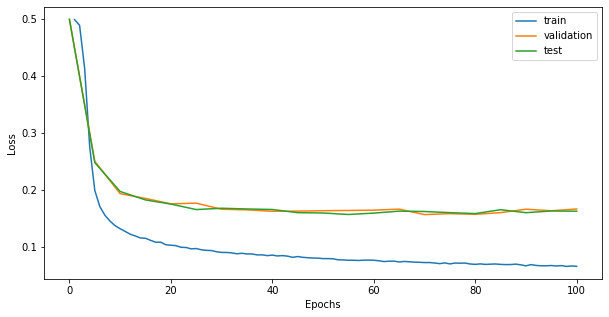

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, EPOCHS+1), best_model_history['loss'], label="train")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['val_loss'], label="validation")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history['test_loss'], label="test")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

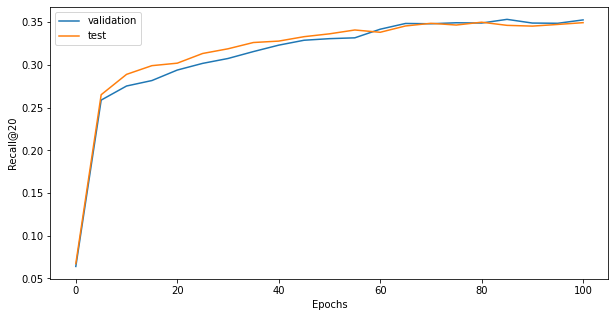

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_recall@{K}'], label="validation")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_recall@{K}'], label="test")

plt.xlabel('Epochs')
plt.ylabel(f'Recall@{K}')
plt.legend(loc='upper left')
plt.show()

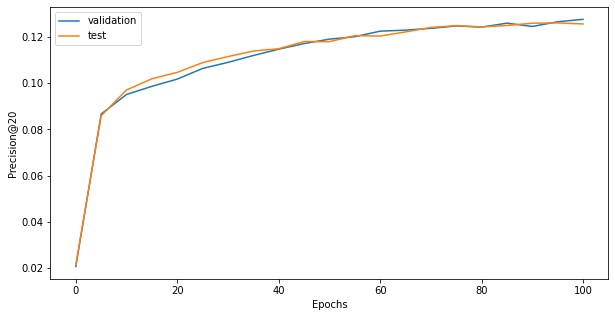

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'val_precision@{K}'], label="validation")
plt.plot(np.arange(0, EPOCHS+1, EVAL_STEPS), best_model_history[f'test_precision@{K}'], label="test")

plt.xlabel('Epochs')
plt.ylabel(f'Precision@{K}')
plt.legend(loc='upper left')
plt.show()

## Evaluation of ML model: LightFM

In [87]:
%%capture
!pip install lightfm

In [88]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k

In [89]:
from scipy.sparse import coo_matrix
# TRAIN
row = train_edge_index[0].cpu().numpy()
col = train_edge_index[1].cpu().numpy()
data = np.ones(train_edge_index.numpy().shape[1])
train_sparse_matrix = coo_matrix((data, (row, col)), shape=(n_users, n_items))
# TEST
row = test_edge_index[0].cpu().numpy()
col = test_edge_index[1].cpu().numpy()
data = np.ones(test_edge_index.numpy().shape[1])
test_sparse_matrix = coo_matrix((data, (row, col)), shape=(n_users, n_items))

In [90]:
# Instantiate and train the model
model = LightFM(
    no_components=64,
    learning_schedule='adagrad',
    loss='bpr',
    learning_rate=LR
)
model = model.fit(train_sparse_matrix, epochs=100, num_threads=4)

In [91]:
# Evaluate the trained model
test_recall = recall_at_k(model, test_sparse_matrix, k=K).mean()
test_precision = precision_at_k(model, test_sparse_matrix, k=K).mean()
print(f'Recall@{K}:\t{test_recall:.4f}')
print(f'Precision@{K}:\t{test_precision:.4f}')

Recall@20:	0.1640
Precision@20:	0.0459
